In [421]:
from sympy import init_session
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.integrate as it
from scipy.signal import savgol_filter


init_session(use_latex = True)

IPython console for SymPy 1.13.2 (Python 3.10.1-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.2/



In [422]:
# Size
a = 1.78 * 0.0254 #m R2
b = 12.1 * 0.0254 #m R3
c = 3.17 * 0.0254 #m R4
d = 13.4 * 0.0254 #m R1
a, b, c, d

In [423]:
m = 3.48 #kg
l = 24.5 * 0.0254 #length of wiper m
I = 1/3 * m * l**2 + m * (l/2 * sqrt(3))**2 + 1/3 * m * (l/2)**2 #moment of inertia about com kgm^2 
mu_k = 0.3  # coefficien()t of kinetic friction
g = 9.81  # gravity (m/s^2)
theta = 25 #degs
n = 3 # order of polynomial filtering 
b = 53 # window size for filter need to be odd number
I

In [424]:
#Parameters
motor_torque = 30 #NM 
df = pd.read_csv("4bardata.txt", sep='\t' , header = None, names = ["time [s]", "theta_2 [rad]", "theta_3 [rad]", "theta_4 [rad]", "theta_2 [°]","theta_3 [°]","theta_4 [°]","omega_2 [rad/s]", "omega_43 [rad/s]","omega_4 [rad/s]","alpha_2 [rad/s^2]","alpha_3 [rad/s^2]","alpha_4 [rad/s^2]"])


In [425]:
#Torque Calculations

tau_out = []
err = 15 # to eliminate spikes and use small angle approximation
for i in range(df.shape[0]):
    theta_a = 180.0 - df["theta_2 [°]"][i] + df["theta_3 [°]"][i] # inner angle between link a and b
    theta_b = df["theta_4 [°]"][i]- df["theta_3 [°]"][i] # inner angle between link b and c
    if abs(theta_a) > err and abs(theta_a) < (180-err):
        temp1 = motor_torque * ((c * np.sin(np.deg2rad(theta_b)))/ (a * np.sin(np.deg2rad(theta_a))))
        tau_out.append(temp1)
    elif abs(theta_b) < err and abs(theta_a) > (180-err):
        temp2 = motor_torque * (c * np.sin(np.deg2rad(theta_b)))/ (a * theta_a)
        tau_out.append(temp2)
    else: 
        temp3 = motor_torque * (c* np.sin(np.deg2rad(theta_b)))/ (a* theta_a)
        tau_out.append(temp3)

filter_tau_out = savgol_filter(tau_out, b, n)
df["Input_torque [nm]"] = filter_tau_out
print(df["Input_torque [nm]"].to_string())

0      -3.032241
1       6.976908
2      16.207158
3      24.682378
4      32.426439
5      39.463210
6      45.816561
7      51.510361
8      56.568479
9      61.014786
10     64.873152
11     68.167444
12     70.921535
13     73.159292
14     74.904585
15     76.181285
16     77.013260
17     77.424381
18     77.438516
19     77.079537
20     76.371311
21     75.337709
22     74.002601
23     72.389856
24     70.523343
25     68.426932
26     66.124494
27     66.225349
28     65.240356
29     63.281525
30     60.423046
31     56.718253
32     52.208057
33     46.925554
34     40.898702
35     40.006960
36     38.258319
37     35.933313
38     33.182731
39     30.099674
40     26.748291
41     23.176891
42     19.424529
43     15.524564
44     11.506706
45      7.398240
46      3.224796
47     -0.989155
48     -5.219969
49     -9.444587
50    -13.640371
51    -17.784963
52    -21.856165
53    -25.831830
54    -29.689733
55    -33.407422
56    -36.962029
57    -40.330002
58    -43.4867

In [426]:
# Equations of Motion
acceleration_t = []
force_spring = []
alpha_w = []
F_n = []
F_friction = []

for i in range(df.shape[0]):
    temp7 = - (df["Input_torque [nm]"][i] * l) / ( m * l**2 - 2 * I)  #a_tan
    acceleration_t.append(temp7)
    
    temp8 = - (df["Input_torque [nm]"][i]) / ( m * l**2 - 2 * I) #use a = r*alpha to find alpha
    alpha_w.append(temp8)
    
    temp9 = (df["Input_torque [nm]"][i])/l - m * acceleration_t[i] #friction
    F_friction.append(temp8)

    temp10 = F_friction[i] / mu_k #Normal force
    F_n.append(temp10)
    
    temp11 = F_n[i] - m * g * np.cos(np.radians(theta)) #Spring Force
    force_spring.append(temp11)
    
df["F_normal [N]"] = F_n
df["Friction [N]"] = F_friction
df["acc_tan [m/s^2]"] = acceleration_t
df["alpha_w [rad/s^2]"] = alpha_w
df["F_spring [N]"]= force_spring
df.head()


,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],alpha_2 [rad/s^2],alpha_3 [rad/s^2],alpha_4 [rad/s^2],Input_torque [nm],F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N]
0,0.00,0.0000,0.265046,1.555820,0.000000,15.186043,89.141940,6.81,-1.036432,-1.036432,0.0,0.121798,29.960644,-3.032241,-5.62503019456506,-1.68750905836952,-1.05013688702335,-1.68750905836952,-36.5652904746518
1,0.01,0.0000,0.265046,1.555820,0.000000,15.186043,89.141940,6.81,-1.036432,-1.036432,0.0,0.121798,29.960644,6.976908,12.9426780621030,3.88280341863089,2.41626856741400,3.88280341863089,-17.9975822179838
2,0.02,0.0681,0.254700,1.546965,3.901843,14.593232,88.634560,6.81,-1.031730,-0.733699,0.0,0.805461,30.537016,16.207158,30.0654715806607,9.01964147419822,5.61292288939355,9.01964147419822,-0.874788699426048
3,0.03,0.1362,0.244433,1.541161,7.803685,14.004996,88.302003,6.81,-1.020598,-0.426671,0.0,1.406589,30.819922,24.682378,45.7876302507870,13.7362890752361,8.54809269151943,13.7362890752361,14.8473699707002
4,0.04,0.2043,0.234307,1.538436,11.705528,13.424778,88.145894,6.81,-1.003890,-0.118261,0.0,1.920327,30.815159,32.426439,60.1534339621605,18.0460301886481,11.2300445863957,18.0460301886481,29.2131736820737


In [427]:
#Use trapezoidal rule to find v by integration
dt = 0.01
v_tan = it.cumulative_trapezoid(df["acc_tan [m/s^2]"], df["time [s]"], initial = 0)
omega_w = it.cumulative_trapezoid(df["alpha_w [rad/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
df["vel_tan [m/s]"] = v_tan
df["omega_w [rad/s]"] = omega_w


In [428]:
#Use trapezoidal rule to find position by integration
dt = 0.01
tan = it.cumulative_trapezoid(df["vel_tan [m/s]"], dx = dt, initial = 0)
theta_w = it.cumulative_trapezoid(df["omega_w [rad/s]"], x = df["time [s]"],dx = dt, initial = 0)
df["pos_tan [m]"] = tan 
df["pos_angular [rad]"] = theta_w
df["pos_angular [°]"] = (theta_w * 180 /np.pi) % 360

In [429]:
df.head()


,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],...,F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N],vel_tan [m/s],omega_w [rad/s],pos_tan [m],pos_angular [rad],pos_angular [°]
0,0.00,0.0000,0.265046,1.555820,0.000000,15.186043,89.141940,6.81,-1.036432,-1.036432,...,-5.62503019456506,-1.68750905836952,-1.05013688702335,-1.68750905836952,-36.5652904746518,0,0,0,0,0.0
1,0.01,0.0000,0.265046,1.555820,0.000000,15.186043,89.141940,6.81,-1.036432,-1.036432,...,12.9426780621030,3.88280341863089,2.41626856741400,3.88280341863089,-17.9975822179838,0.00683065840195325,0.0109764718013068,3.41532920097663e-5,5.48823590065342e-5,0.00314452754079621
2,0.02,0.0681,0.254700,1.546965,3.901843,14.593232,88.634560,6.81,-1.031730,-0.733699,...,30.0654715806607,9.01964147419822,5.61292288939355,9.01964147419822,-0.874788699426048,0.0469766156859910,0.0754886962654524,0.000303189662449488,0.000487208199340330,0.0279149735663694
3,0.03,0.1362,0.244433,1.541161,7.803685,14.004996,88.302003,6.81,-1.020598,-0.426671,...,45.7876302507870,13.7362890752361,8.54809269151943,13.7362890752361,14.8473699707002,0.117781693590556,0.189268349012624,0.00112698120883222,0.00181099342573071,0.103762280020308
4,0.04,0.2043,0.234307,1.538436,11.705528,13.424778,88.145894,6.81,-1.003890,-0.118261,...,60.1534339621605,18.0460301886481,11.2300445863957,18.0460301886481,29.2131736820737,0.216672379980132,0.348179945332045,0.00279925157668566,0.00449823489745406,0.257729874882580


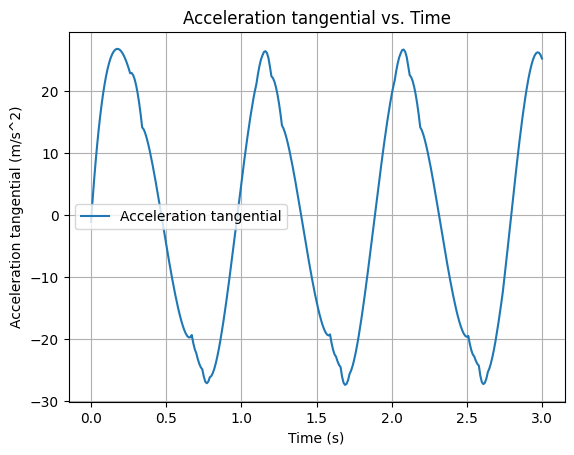

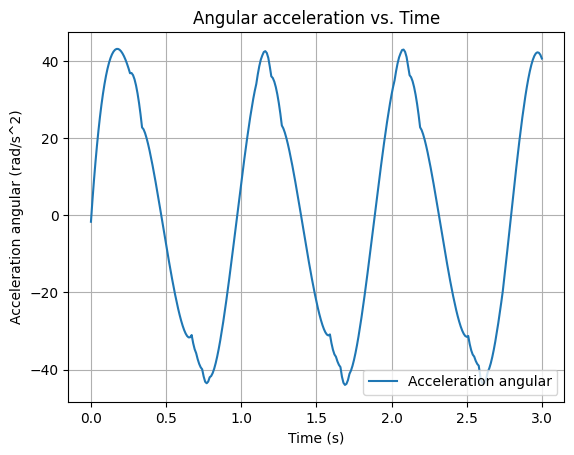

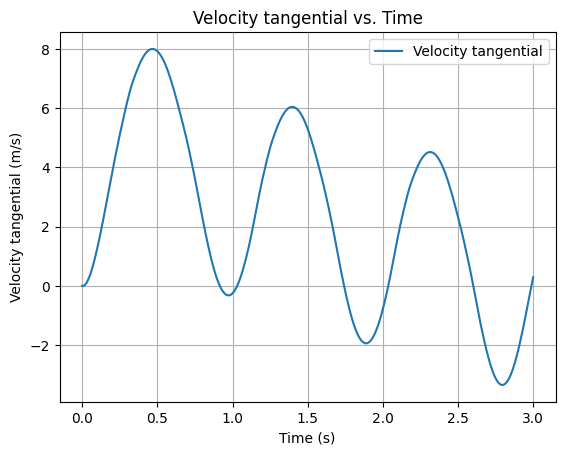

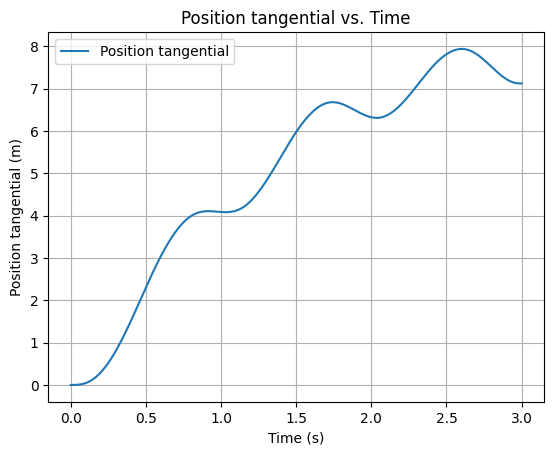

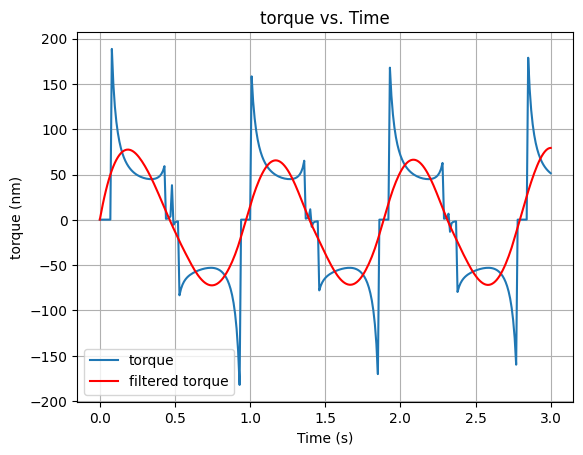

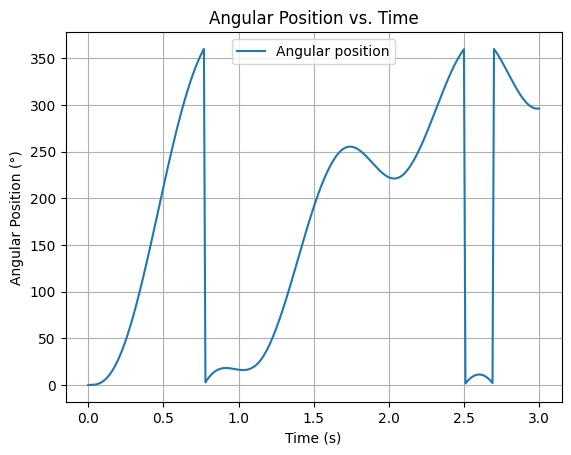

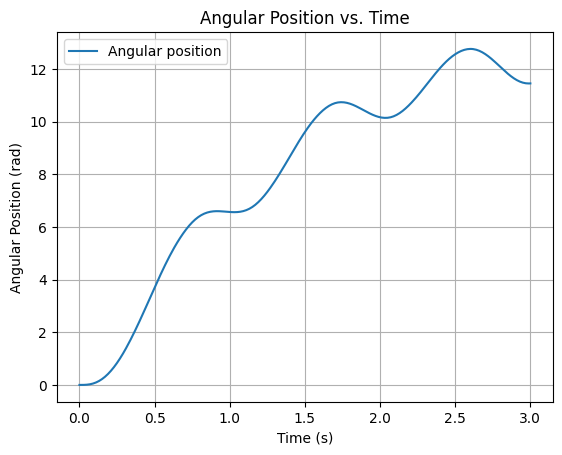

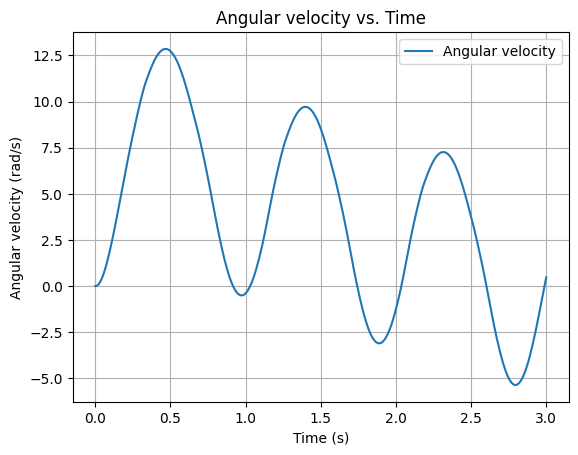

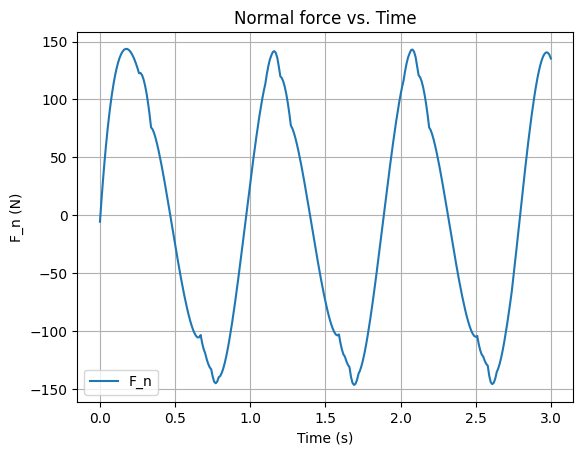

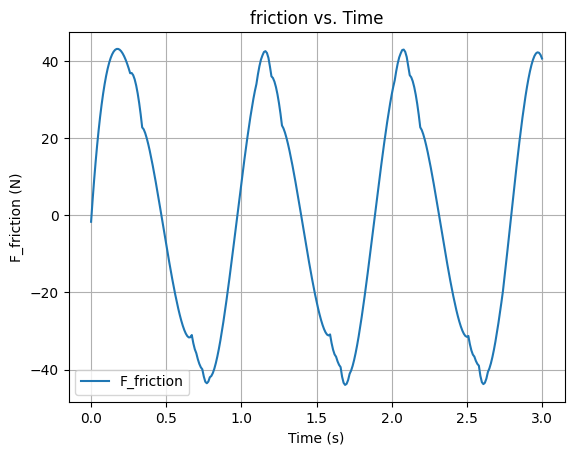

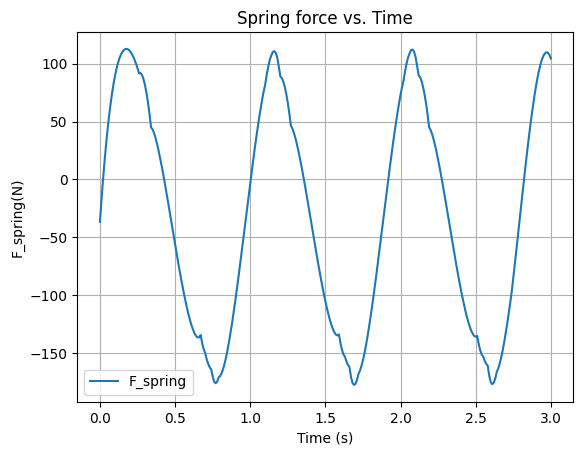

In [430]:
# Plotting the graphs

plt.plot(df["time [s]"], df["acc_tan [m/s^2]"], label='Acceleration tangential')
#plt.plot(df["time [s]"], l * df["alpha_4 [rad/s^2]"], label='FR Acceleration', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration tangential (m/s^2)')
plt.title('Acceleration tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["alpha_w [rad/s^2]"], label='Acceleration angular')
#plt.plot(df["time [s]"], df["alpha_4 [rad/s^2]"], label='ang accel fr fr ', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration angular (rad/s^2)')
plt.title('Angular acceleration vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["vel_tan [m/s]"] , label='Velocity tangential')
plt.xlabel('Time (s)')
plt.ylabel('Velocity tangential (m/s)')
plt.title('Velocity tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["pos_tan [m]"] , label='Position tangential')
plt.xlabel('Time (s)')
plt.ylabel('Position tangential (m)')
plt.title('Position tangential vs. Time')
plt.legend()
plt.grid()
plt.show()


plt.plot(df["time [s]"], tau_out, label='torque')
plt.xlabel('Time (s)')
plt.ylabel('torque (nm)')
plt.title('torque vs. Time')

plt.grid()
yhat = savgol_filter(df["Input_torque [nm]"], b, n) # window size b, polynomial order n
plt.plot(df["time [s]"], yhat, label = 'filtered torque', color = 'red')
plt.legend()
plt.show()

plt.plot(df["time [s]"], df["pos_angular [°]"] , label='Angular position')
plt.xlabel('Time (s)')
plt.ylabel('Angular Position (°)')
plt.title('Angular Position vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["pos_angular [rad]"] , label='Angular position')
plt.xlabel('Time (s)')
plt.ylabel('Angular Position (rad)')
plt.title('Angular Position vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["omega_w [rad/s]"] , label='Angular velocity')
plt.xlabel('Time (s)')
plt.ylabel('Angular velocity (rad/s)')
plt.title('Angular velocity vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["F_normal [N]"], label='F_n')
plt.xlabel('Time (s)')
plt.ylabel('F_n (N)')
plt.title('Normal force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["Friction [N]"], label='F_friction')
plt.xlabel('Time (s)')
plt.ylabel('F_friction (N)')
plt.title('friction vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["F_spring [N]"], label='F_spring')
plt.xlabel('Time (s)')
plt.ylabel('F_spring(N)')
plt.title('Spring force vs. Time')
plt.legend()
plt.grid()
plt.show()

